<a href="https://colab.research.google.com/github/catastropiyush/chocos/blob/main/Adaptive_Muon_Momentum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
def zeropower_via_svd(G, steps=None):
    U, _, V = G.svd()
    return U @ V.T

@torch.compile
def zeropower_via_newtonschulz5(G, steps=10, eps=1e-7):
    """
    Newton-Schulz iteration to compute the zeroth power / orthogonalization of G.
    """
    assert len(G.shape) == 2
    a, b, c = (3.4445, -4.7750, 2.0315)
    X = G.bfloat16()
    X /= (X.norm() + eps)  # Ensure top singular value <= 1
    if G.size(0) > G.size(1):
        X = X.T
    for _ in range(steps):
        A = X @ X.T
        B = b * A + c * A @ A
        X = a * X + B @ X
    if G.size(0) > G.size(1):
        X = X.T
    X = (G.T.type_as(X) @ X).norm() * X  # scale orthogonalized gradient by the dual norm of the original gradient

    return X

class Muon(torch.optim.Optimizer):
    """
    Muon - MomentUm Orthogonalized by Newton-Schulz

    Muon runs SGD with momentum, followed by an orthogonalization step using the
    Newton-Schulz iteration.
    """

    def __init__(self, params, lr=0.02, momentum=0.95, nesterov=True, backend_steps=5):
        defaults = dict(lr=lr, momentum=momentum, nesterov=nesterov, backend_steps=backend_steps)
        super().__init__(params, defaults)

    def step(self, closure=None):
        """
        Performs a single optimization step.
        """
        if closure is not None:
            closure()

        for group in self.param_groups:
            lr = group["lr"]
            momentum = group["momentum"]
            nesterov = group["nesterov"]
            backend_steps = group["backend_steps"]

            for p in group["params"]:
                if p.grad is None:
                    continue
                g = p.grad.data
                state = self.state[p]

                # Initialize momentum buffer
                if "momentum_buffer" not in state:
                    state["momentum_buffer"] = torch.zeros_like(p.data)
                buf = state["momentum_buffer"]

                # Apply momentum update
                buf.mul_(momentum).add_(g, alpha=1 - momentum)


                # Apply orthogonalization using Newton-Schulz
                if len(g.shape) == 2:  # Only orthogonalize 2D tensors
                    buf = zeropower_via_newtonschulz5(buf, steps=backend_steps)


                # if momentum :
                #     # Apply caution logic
                #     mask = buf.signbit() ^ g.signbit()  # Compare momentum with gradient
                #     buf = buf.masked_fill(mask, 0)  # Mask the updates
                #     scale = mask.numel() / (mask.numel() - mask.sum()).clamp(min=1)
                #     buf.mul_(scale)

                # Apply the update
                p.data.add_(buf, alpha=-lr)

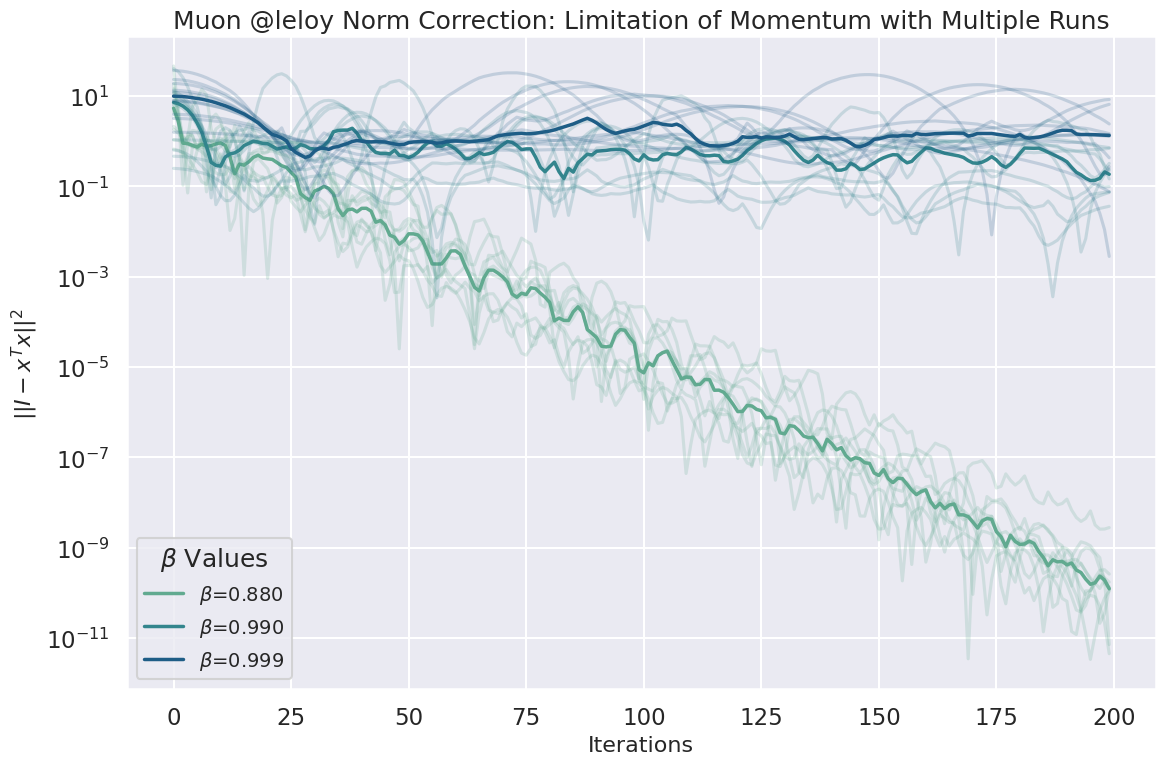

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np

# Set Seaborn style with dark theme
sns.set(style="darkgrid", context="talk", palette="crest")

# Experiment parameters
runs = 10  # Number of runs for averaging
iterations = 200
#betas = [0.88,0.99,0.999]#
betas = np.linspace(0, 0.999, 10)  # Smaller values of beta

# Storage for results
results = {}
n = 2
# Perform experiments
x0 = torch.randn(n,n, requires_grad=True)  # Initial tensor
for beta in betas:
    all_runs = []
    for _ in range(runs):
        x0 = torch.randn(n,n, requires_grad=True)  # Initial tensor
        # Reset x for each run
        x = x0.clone().detach().requires_grad_(True)
        opt = Muon([x], lr= 0.1, momentum=beta,nesterov=True,backend_steps=100)
        f_values = []

        for _ in range(iterations):
            # loss = (1 - torch.sum(x * x))**2 # vector
            loss = torch.linalg.norm(torch.eye(n) - x.T @ x)**2
            f_values.append(loss.item())  # Store the loss value
            loss.backward()
            opt.step()
            opt.zero_grad()

        all_runs.append(f_values)

    results[beta] = np.array(all_runs)

# Generate a custom color palette to handle all beta values
palette = sns.color_palette("crest", len(betas))

# Plot results
plt.figure(figsize=(12, 8))

for idx, (beta, f_values) in enumerate(results.items()):
    median_trajectory = np.median(f_values, axis=0)
    sns.lineplot(
        x=range(iterations),
        y=median_trajectory,
        label=rf"$\beta$={beta:.3f}",
        linewidth=2.5,
        color=palette[idx]
    )

    # Plot individual runs with low alpha
    for run in f_values:
        plt.plot(
            range(iterations),
            run,
            color=palette[idx],
            alpha=0.2
        )

plt.xlabel("Iterations", fontsize=16)
plt.ylabel(r"$||I - x^T x||^2$", fontsize=16)
plt.title("Muon @leloy Norm Correction: Limitation of Momentum with Multiple Runs", fontsize=18)
plt.legend(title=r"$\beta$ Values", fontsize=14)
plt.yscale("log")
plt.tight_layout()
plt.show()

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple, Dict, Optional
from dataclasses import dataclass

# Utility functions
def matrix_power(matrix: torch.Tensor, power: float, eps: float = 1e-7) -> torch.Tensor:
    """Compute matrix power using eigendecomposition."""
    device = matrix.device
    matrix = matrix.cpu()
    eigenvalues, eigenvectors = torch.linalg.eigh(matrix)
    eigenvalues = eigenvalues.clamp(min=eps)
    powered_eigenvalues = eigenvalues.pow(power)
    powered_matrix = eigenvectors @ torch.diag(powered_eigenvalues) @ eigenvectors.t()
    return powered_matrix.to(device)

# Muon Optimizer Implementation
@torch.compile
def zeropower_via_newtonschulz5(G, steps=10, eps=1e-7):
    """Newton-Schulz iteration for matrix orthogonalization."""
    a, b, c = (3.4445, -4.7750, 2.0315)
    X = G.bfloat16()
    X /= (X.norm() + eps)

    if G.size(0) > G.size(1):
        X = X.T
    for _ in range(steps):
        A = X @ X.T
        B = b * A + c * A @ A
        X = a * X + B @ X
    if G.size(0) > G.size(1):
        X = X.T
    X = (G.T.type_as(X) @ X).norm() * X
    return X

class Muon(torch.optim.Optimizer):
    """Muon optimizer with Newton-Schulz orthogonalization."""

    def __init__(self, params, lr=0.02, momentum=0.95, nesterov=True, backend_steps=5):
        defaults = dict(lr=lr, momentum=momentum, nesterov=nesterov, backend_steps=backend_steps)
        super().__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            lr = group["lr"]
            momentum = group["momentum"]
            backend_steps = group["backend_steps"]

            for p in group["params"]:
                if p.grad is None:
                    continue
                g = p.grad.data
                state = self.state[p]

                if "momentum_buffer" not in state:
                    state["momentum_buffer"] = torch.zeros_like(p.data)
                buf = state["momentum_buffer"]

                buf.mul_(momentum).add_(g, alpha=1 - momentum)

                if len(g.shape) == 2:
                    buf = zeropower_via_newtonschulz5(buf, steps=backend_steps)

                p.data.add_(buf, alpha=-lr)

        return loss

# Shampoo Optimizer Implementation
class Shampoo(torch.optim.Optimizer):
    """Shampoo optimizer with matrix preconditioning."""

    def __init__(self, params, lr=1e-1, beta1=0.9, beta2=0.999, eps=1e-7):
        defaults = dict(lr=lr, beta1=beta1, beta2=beta2, eps=eps)
        super().__init__(params, defaults)

        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                state['step'] = 0
                state['momentum_buffer'] = torch.zeros_like(p.data)

                if p.dim() == 2:
                    rows, cols = p.shape
                    state['left_precond'] = torch.eye(rows, device=p.device)
                    state['right_precond'] = torch.eye(cols, device=p.device)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                grad = p.grad.data
                state = self.state[p]
                state['step'] += 1

                lr = group['lr']
                beta1 = group['beta1']
                beta2 = group['beta2']
                eps = group['eps']

                momentum_buffer = state['momentum_buffer']

                if p.dim() == 2:
                    # Update preconditioners
                    left_precond = state['left_precond']
                    right_precond = state['right_precond']

                    # Update left preconditioner
                    left_update = grad @ grad.t()
                    left_precond = beta2 * left_precond + (1 - beta2) * left_update

                    # Update right preconditioner
                    right_update = grad.t() @ grad
                    right_precond = beta2 * right_precond + (1 - beta2) * right_update

                    # Store updated preconditioners
                    state['left_precond'] = left_precond
                    state['right_precond'] = right_precond

                    # Compute preconditioned gradient
                    left_precond_inv = matrix_power(left_precond, -0.25, eps)
                    right_precond_inv = matrix_power(right_precond, -0.25, eps)
                    precond_grad = left_precond_inv @ grad @ right_precond_inv

                    # Update momentum with preconditioned gradient
                    momentum_buffer.mul_(beta1).add_(precond_grad, alpha=1 - beta1)
                else:
                    # Regular momentum update for non-2D parameters
                    momentum_buffer.mul_(beta1).add_(grad, alpha=1 - beta1)

                # Apply update
                p.data.add_(momentum_buffer, alpha=-lr)

        return loss

# Comparison utilities
def create_test_problem(size=10):
    """Create a test optimization problem."""
    X = torch.randn(size, size, requires_grad=True)
    target = torch.eye(size)
    return X, target

def compute_loss(X, target):
    """Compute the loss for the optimization problem."""
    return torch.norm(X.t() @ X - target)

def run_optimization(optimizer, X, target, n_iterations=200):
    """Run optimization for a given number of iterations."""
    losses = []
    for _ in range(n_iterations):
        optimizer.zero_grad()
        loss = compute_loss(X, target)
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
    return losses

def compare_optimizers(problem_size=10, n_runs=5, n_iterations=200):
    """Compare different optimizers."""
    results = {}
    optimizer_configs = {
        'Shampoo (β₁=0.9)': lambda x: Shampoo([x], lr=0.1, beta1=0.9),
        'Shampoo (β₁=0.99)': lambda x: Shampoo([x], lr=0.1, beta1=0.99),
        'Muon (β=0.9)': lambda x: Muon([x], lr=0.1, momentum=0.9),
        'Muon (β=0.99)': lambda x: Muon([x], lr=0.1, momentum=0.99)
    }

    for name, opt_fn in optimizer_configs.items():
        all_runs = []
        for _ in range(n_runs):
            X, target = create_test_problem(problem_size)
            optimizer = opt_fn(X)
            losses = run_optimization(optimizer, X, target, n_iterations)
            all_runs.append(losses)
        results[name] = np.array(all_runs)

    return results

def plot_results(results, title="Optimizer Comparison"):
    """Plot comparison results."""
    plt.figure(figsize=(12, 8))
    sns.set_style("darkgrid")

    for name, runs in results.items():
        median = np.median(runs, axis=0)
        q25 = np.percentile(runs, 25, axis=0)
        q75 = np.percentile(runs, 75, axis=0)

        plt.plot(median, label=name, linewidth=2)
        plt.fill_between(range(len(median)), q25, q75, alpha=0.2)

    plt.yscale('log')
    plt.xlabel('Iterations', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.tight_layout()
    plt.show()

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


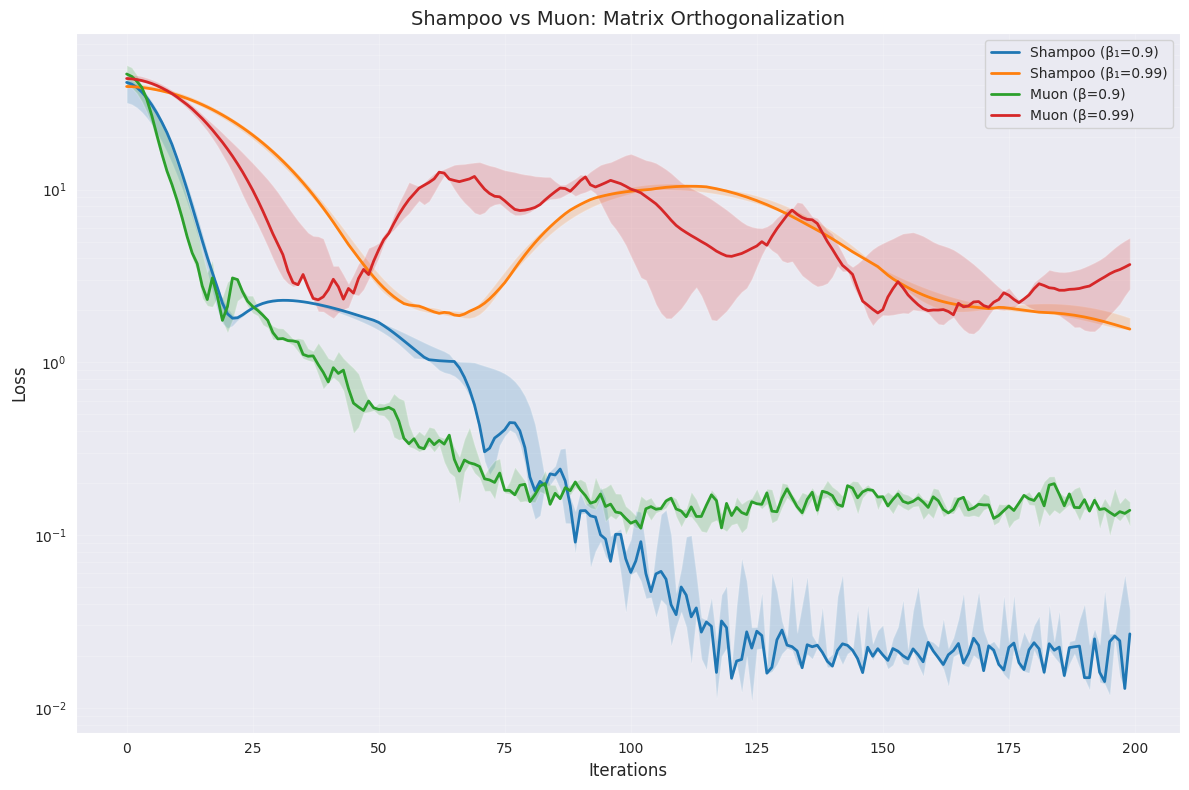

In [6]:
# Example usage
if __name__ == "__main__":
    # Set random seed for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)

    # Run comparison
    results = compare_optimizers(
        problem_size=10,
        n_runs=5,
        n_iterations=200
    )

    # Plot results
    plot_results(results, "Shampoo vs Muon: Matrix Orthogonalization")